In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_val_score, GridSearchCV, StratifiedKFold

In [4]:
rer = pd.read_csv("./Stations/CLH.csv", low_memory=False)

# Cleaning again

In [7]:
rer['nearest_datetime'] = pd.to_datetime(rer['nearest_datetime'], format='%Y-%m-%d %H:%M:%S')

rer = rer.sort_values(by='destination_name', ascending=False)
rer['destination_name'] = pd.factorize(rer["destination_name"])[0]

rer = rer.sort_values(by='nearest_datetime', ascending=True)

rer["departure_status"] = rer["departure_status"].astype("string")
rer["is_day"] = rer["is_day"].astype(int)

rer['pourc_validations'] = rer['pourc_validations'].fillna(0)

rer = rer.drop(['stop_name', "timestamp", "real_departure", "scheduled_arrival", "scheduled_departure", "Période", "real_arrival", "arrival_difference", "departure_difference", "ArRTown", "Date", "day_type", "is_bank_holiday", "is_weekend"], axis=1)

In [9]:
rer_learn = rer
rer_test = rer

start_date = pd.to_datetime('2024-11-02 00:00:00')
end_date = pd.to_datetime('2025-01-12 23:59:59')

start_date2 = pd.to_datetime('2025-01-13 00:00:00')
end_date2 = pd.to_datetime('2025-01-19 23:59:59')

rer_learn = rer_learn[(rer_learn['nearest_datetime'] >= start_date) & (rer_learn['nearest_datetime'] <= end_date)]
rer_test = rer_test[(rer_test['nearest_datetime'] >= start_date2) & (rer_test['nearest_datetime'] <= end_date2)]


In [11]:
rer_learn = rer_learn.copy()
rer_learn.drop(['nearest_datetime'], axis=1, inplace=True)  # Drop the original datetime column if not needed

rer_test = rer_test.copy()
rer_test.drop(['nearest_datetime'], axis=1, inplace=True)  # Drop the original datetime column if not needed

In [13]:
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)  #% of missing values
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)  #create result table
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns

print(missing_values_table(rer_learn)) 

There are 0 columns that have missing values.
Empty DataFrame
Columns: [Missing Values, % of Total Values]
Index: []


# PCA

In [82]:
#Standardise continuous numerical vars
numerical_vars = rer.select_dtypes(include=['float64'])

scaler = StandardScaler()
numerical_vars_scaled = scaler.fit_transform(numerical_vars)

pca = PCA()
pca_results = pca.fit_transform(numerical_vars_scaled)

In [83]:
pca_df = pd.DataFrame(
    pca_results,
    columns=[f'PC{i+1}' for i in range(pca_results.shape[1])]
)

explained_variance = pca.explained_variance_ratio_

print("Explained Variance Ratio:", explained_variance)
print("PCA DataFrame Head:\n", pca_df.head())

Explained Variance Ratio: [2.46828989e-01 1.17601517e-01 9.47172973e-02 8.10644020e-02
 5.65545055e-02 5.45701141e-02 4.91658036e-02 4.56963747e-02
 4.54801334e-02 4.35536478e-02 4.28929694e-02 3.94886360e-02
 3.55621004e-02 2.40749042e-02 1.57731877e-02 5.52642469e-03
 8.11739429e-04 6.32515513e-04 4.73819379e-06 2.77065131e-16
 1.16386322e-16 0.00000000e+00]
PCA DataFrame Head:
         PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -2.197641 -2.325296  2.316694  0.446286  0.420453 -4.155945 -0.276513   
1 -2.452500 -1.311707  1.518329  0.165865 -0.010646 -4.601844  0.470129   
2 -2.595953 -0.820179  1.251608 -0.177819 -0.159397 -4.770596  0.342550   
3 -2.594906 -0.823458  1.265869 -0.181482 -0.150173 -4.764458  0.194994   
4 -2.653366 -0.598793  0.910105 -0.173462 -0.371873 -5.226765 -0.301478   

        PC8       PC9      PC10  ...      PC13      PC14      PC15      PC16  \
0 -2.483109 -0.581306  2.393583  ... -3.459093 -0.859804  0.907444 -0.061454   
1 -0.

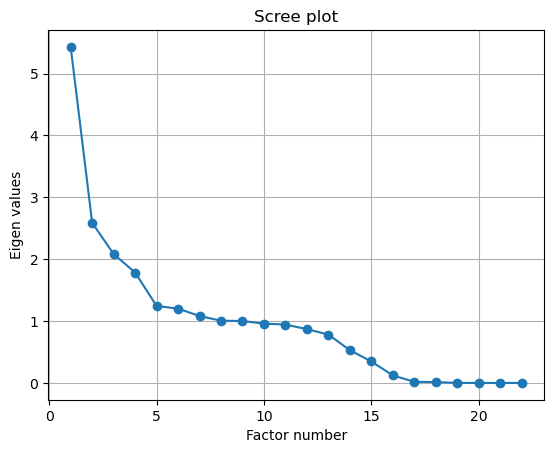

In [86]:
eigval = pca.explained_variance_

k = len(eigval)

plt.plot(np.arange(1, k + 1), eigval, marker='o')
plt.title("Scree plot")
plt.ylabel("Eigen values")
plt.xlabel("Factor number")
plt.grid(True)
plt.savefig('Screeplot_CLH.png', bbox_inches='tight', dpi=300)
plt.show()

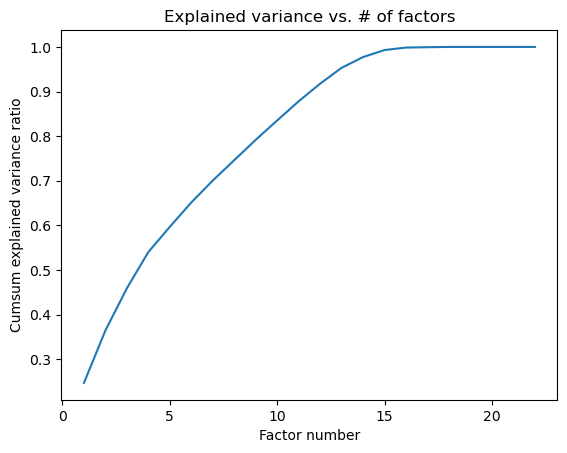

In [87]:
plt.plot(np.arange(1,k+1),np.cumsum(pca.explained_variance_ratio_)) 
plt.title("Explained variance vs. # of factors") 
plt.ylabel("Cumsum explained variance ratio") 
plt.xlabel("Factor number") 
plt.savefig('CumSumPlot_CLH.png', bbox_inches='tight', dpi=300)
plt.show()

In [89]:
## 10 factors picked for expainability

In [90]:
eigval

array([5.43036432e+00, 2.58729368e+00, 2.08382911e+00, 1.78345841e+00,
       1.24422812e+00, 1.20057049e+00, 1.08167289e+00, 1.00534367e+00,
       1.00058626e+00, 9.58202585e-01, 9.43667320e-01, 8.68770241e-01,
       7.82384444e-01, 5.29660237e-01, 3.47018217e-01, 1.21584177e-01,
       1.78586837e-02, 1.39156656e-02, 1.04242693e-04, 6.09557496e-15,
       2.56055876e-15, 0.00000000e+00])

In [94]:
print(np.cumsum(pca.explained_variance_ratio_))

[0.24682899 0.36443051 0.4591478  0.54021221 0.59676671 0.65133682
 0.70050263 0.746199   0.79167914 0.83523278 0.87812575 0.91761439
 0.95317649 0.97725139 0.99302458 0.99855101 0.99936275 0.99999526
 1.         1.         1.         1.        ]


# Logistic Regression

In [16]:
rer_learn_X = rer_learn.drop('departure_status', axis=1)  # (exclude target)
rer_learn_Y = rer_learn['departure_status']  # Target variable
rer_learn_Y = rer_learn_Y.apply(lambda x: 1 if x in ['delayed', 'cancelled'] else 0)

In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(rer_learn_X, 
                                                    rer_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=rer_learn_Y)

In [20]:
#Numerical features => standard scaling 

numeric_features = ['temperature_2m', 'precipitation', 'rain', 'snowfall', 'wind_gusts_10m', 'wind_speed_10m', 'visibility']

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

In [22]:
from sklearn.linear_model import ElasticNet, Lasso, LogisticRegression
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)) 
])

In [24]:
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'model__l1_ratio': [0.1, 0.5, 0.7, 0.9],  # Elastic Net mix
}

In [26]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['temperature_2m',
                                                                          'precipitation',
                                                                          'rain',
                                                                          'snowfall',
                                                                          'wind_gusts_10m',
                                                                          'wind_speed_10m',
                                                                          'visibility'])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           penalty='elasticnet',
                                                           solver='saga'))]),
             param_grid={'model__C': [0.01, 0.1, 1, 10, 100],
                         'model__l1_ratio': [0.1, 0.5, 0.7, 0.9]},
             scoring='accuracy')

In [27]:
best_model = grid_search.best_estimator_
print(best_model.get_params())

{'memory': None, 'steps': [('preprocessor', ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'precipitation', 'rain',
                                  'snowfall', 'wind_gusts_10m',
                                  'wind_speed_10m', 'visibility'])])), ('model', LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   solver='saga'))], 'verbose': False, 'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['temperature_2m', 'precipitation', 'rain',
                                  'snowfall', 'wind_gusts_10m',
                                  'wind_speed_10m', 'visibility'])]), 'model': LogisticRegression(C=0.01, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                   solver='saga'), 'preprocessor__force_int_remainder_cols': True, 'preprocessor__n_jobs': None, 'preprocessor__remainder': 'drop', 'preprocessor__sparse_t

In [28]:
rer_test_X = rer_test.drop('departure_status', axis=1)  # Features (exclude target)
rer_test_Y = rer_test['departure_status'] 
rer_test_Y = rer_test_Y.apply(lambda x: 1 if x in ['delayed', 'cancelled'] else 0)


In [29]:
y_pred_train = best_model.predict(X_train)    #the test set of the learn data
y_pred_test = best_model.predict(rer_test_X)

In [30]:
print(f"Training Accuracy: {accuracy_score(Y_train, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(rer_test_Y, y_pred_test):.4f}")

Training Accuracy: 0.9906
Test Accuracy: 0.9895


In [31]:
train_pred_vs_true = pd.DataFrame({'True': Y_train, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': rer_test_Y, 
                                  'Predicted': y_pred_test})

In [32]:
conf_matrix = confusion_matrix(rer_test_Y, y_pred_test)
print(conf_matrix)

[[4033    0]
 [  43    0]]


# random forest

In [34]:
rer_learn_X = rer_learn.drop('departure_status', axis=1)  # Features (exclude target)
rer_learn_Y = rer_learn['departure_status']  # Target variable
rer_learn_Y  = rer_learn_Y.apply(lambda x: 1 if x in ['delayed', 'cancelled'] else 0)

X_train, X_test, Y_train, Y_test = train_test_split(rer_learn_X, 
                                                    rer_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    stratify=rer_learn_Y)

In [35]:
rf = RandomForestClassifier(random_state=42)

rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='f1')

In [36]:
rf_cv.fit(X_train, Y_train)
best_model = rf_cv.best_estimator_

print(f"Best hyperparameters: {rf_cv.best_params_}")

Best hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [37]:
rer_test_X = rer_test.drop('departure_status', axis=1)  
rer_test_Y = rer_test['departure_status']  
rer_test_Y  = rer_test_Y.apply(lambda x: 1 if x in ['delayed', 'cancelled'] else 0)


In [38]:
y_pred_train = best_model.predict(X_test)
y_pred_test = best_model.predict(rer_test_X)

print(f"Training Accuracy: {accuracy_score(Y_test, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(rer_test_Y, y_pred_test):.4f}")

train_pred_vs_true = pd.DataFrame({'True': Y_test, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': rer_test_Y, 
                                  'Predicted': y_pred_test})

Training Accuracy: 0.9913
Test Accuracy: 0.9897


In [39]:
conf_matrix = confusion_matrix(rer_test_Y, y_pred_test)
print(conf_matrix)


[[4032    1]
 [  41    2]]


In [40]:
rer_test['departure_status'].value_counts()

departure_status
onTime     4033
delayed      43
Name: count, dtype: Int64

# Resampling

In [42]:
rer_learn_X = rer_learn.drop('departure_status', axis=1)  
rer_learn_Y = rer_learn['departure_status']  
rer_learn_Y = rer_learn_Y.apply(lambda x: 1 if x in ['delayed', 'cancelled'] else 0)


In [43]:
X_train, X_test, Y_train, Y_test = train_test_split(rer_learn_X, 
                                                    rer_learn_Y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                                    stratify=rer_learn_Y)

In [44]:
#Apply SMOTE to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)  # 'auto' resamples to match the majority class size
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

#X_train_resampled and Y_train_resampled are balanced with synthetic data
print(f"Original dataset shape: {X_train.shape}, {Y_train.shape}")
print(f"Resampled dataset shape: {X_train_resampled.shape}, {Y_train_resampled.shape}")

Original dataset shape: (30048, 29), (30048,)
Resampled dataset shape: (59532, 29), (59532,)


In [45]:
rf = RandomForestClassifier(random_state=42)

rf_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

cv_folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_cv = GridSearchCV(rf, rf_grid, cv=cv_folds, n_jobs=-1, scoring='f1')

In [46]:
rf_cv.fit(X_train_resampled, Y_train_resampled)
best_rf = rf_cv.best_estimator_

print(best_rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 150, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [47]:
rer_test_X = rer_test.drop('departure_status', axis=1)  # Features (exclude target)
rer_test_Y = rer_test['departure_status']  # Target variable
rer_test_Y  = rer_test_Y.apply(lambda x: 1 if x in ['delayed', 'cancelled'] else 0)

In [49]:
y_pred_train = best_rf.predict(X_test)
y_pred_test = best_rf.predict(rer_test_X)

print(f"Training Accuracy: {accuracy_score(Y_test, y_pred_train):.4f}")
print(f"Test Accuracy: {accuracy_score(rer_test_Y, y_pred_test):.4f}")

train_pred_vs_true = pd.DataFrame({'True': Y_test, 
                                   'Predicted': y_pred_train})

test_pred_vs_true = pd.DataFrame({'True': rer_test_Y, 
                                  'Predicted': y_pred_test})

Training Accuracy: 0.9923
Test Accuracy: 0.9895


In [50]:
conf_matrix = confusion_matrix(rer_test_Y, y_pred_test)
print(conf_matrix)

[[4033    0]
 [  43    0]]


In [79]:
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=['Actual onTime', 'Actual delay'],  # Replace with your class names
    columns=['Predicted onTime', 'Predicted delay']  # Replace with your class names
)

# Save the confusion matrix as a LaTeX table
latex_table = conf_matrix_df.to_latex(
    index=True,
    caption="Confusion Matrix",
    label="tab:confusion_matrix",
    column_format="|c|c|c|c|",  # Adjust column alignment if necessary
    bold_rows=True
)

# Write to a .tex file
with open("confusion_matrix_CLH.tex", "w") as f:
    f.write(latex_table)

print("Confusion matrix saved to LaTeX format in 'confusion_matrix.tex'")

Confusion matrix saved to LaTeX format in 'confusion_matrix.tex'
